# Vision Transformers (ViT)

Based on "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Dosovitskiy et. al.

In [371]:
from vision.attention2D import Attention
import torch

import pickle
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 

import matplotlib.pyplot as plt

In [372]:
device = torch.device("mps")

In [373]:
# data boiler plate

all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'generative/autoencoders/data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)
data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=True)

## Creating image patches 

This function is at the heart of the ViT, transforming images to patches of images that can be treated as tokens in a sequence

In [374]:
def patchify(x: torch.Tensor, patch_size: int):
    print(x.shape)
    batch_size, channels, width, height = x.shape
    x = x.reshape(batch_size, channels, width // patch_size, patch_size, height // patch_size, patch_size)  # reshape into patches: b, c, w, h -> b, c, num_horizontal, patch_w, num_vertical, patch_h
    print(f"reshaped: {x.shape}")
    x = x.permute(0, 2, 4, 1, 3, 5)  # permute, b, c, num_horizontal, patch_w, num_vertical, patch_h -> b, num_horizontal, num_vertical, channels, patch_w, patch_h
    print(f"permuted: {x.shape}")
    return x.reshape(batch_size, -1, channels * patch_size * patch_size)  # flatten the patches

x_train_2 = patchify(x_train, 16)
x_train_2.shape

torch.Size([40000, 3, 32, 32])
reshaped: torch.Size([40000, 3, 2, 16, 2, 16])
permuted: torch.Size([40000, 2, 2, 3, 16, 16])


torch.Size([40000, 4, 768])

## Transformer related modules

In [375]:
class MLP(nn.Module): 
    """
    Class implementation of a position wise MLP
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float, num_layers: int = 2) -> None:
        super(MLP, self).__init__()
        
        layers = [nn.Linear(d_model, d_ff), nn.GELU()]
        
        for i in range(1, num_layers - 1):
            layers.append(nn.Linear(d_ff, d_ff, bias=True))
            layers.append(nn.GELU())
        
        layers.append(nn.Linear(d_ff, d_model, bias=True))
        self.mlp_layers = nn.Sequential(*layers)
        
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.mlp_layers(self.layer_norm(x))
        return self.dropout(x) + residual


class EncoderLayer(nn.Module):
    """
    Encoder layer block for ViT
    """
    def __init__(
        self, 
        num_heads: int,
        num_channels: int,
        d_linear: int,
        num_linear_layers: int = 2,
        num_groups: int = 8,
        dropout: float = 0.1,
        is_masked: bool = False
    ):
        super(EncoderLayer, self).__init__()
        self.norm1, self.norm2 = nn.LayerNorm(num_channels),  nn.LayerNorm(num_channels)
        self.mha = Attention(dropout, num_heads, num_channels, num_groups)
        self.mlp = MLP(num_channels, d_linear, dropout, num_linear_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.mha(self.norm1(x))
        return self.mlp(self.norm2(h)) + h


class Encoder(nn.Module):
    def __init__(
        self, 
        num_heads: int,
        num_channels: int,
        num_layers: int,
        d_linear: int,
        num_linear_layers: int = 2,
        num_groups: int = 8,
        dropout: float = 0.1,
        is_masked: bool = False
    ):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(
                num_heads, num_channels, d_linear, num_linear_layers, num_groups, dropout, is_masked
            ) for _ in range(num_layers)
        ])
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x 

In [376]:
def positional_embedding(input_tensor: torch.Tensor, output_dim: int, n=10000):
    """
    Naive sin/cosin positional embedding
    """
    p = torch.zeros((input_tensor.shape[-1], output_dim))
    indices = torch.arange(input_tensor.size(-1))
    i_values = torch.arange(int(output_dim/2))
    denominators = torch.float_power(n, 2*i_values/output_dim)
    p[:, 0::2] = torch.sin(indices.unsqueeze(1) / denominators.unsqueeze(0))
    p[:, 1::2] = torch.cos(indices.unsqueeze(1) / denominators.unsqueeze(0))
    return p


class MLPClassicationHead(nn.Module):
    """
    Class implementation of a position wise MLP
    """
    def __init__(
        self,
        num_classes: int,
        num_channels:int,
        d_ff: int,
        num_layers: int = 2,
        dropout: float = 0.1,
    ) -> None:
        super(MLPClassicationHead, self).__init__()

        layers = []
        layers.append(nn.Linear(num_channels, d_ff, bias=True))
        for i in range(1, num_layers - 1):
            layers.append(nn.Linear(d_ff, d_ff, bias=True))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(d_ff, num_classes, bias=True))
        self.mlp_layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp_layers(x)

## Putting it all together 

Whether autoregressive or bert style, transformers natively perform token prediction. The novelty in the design of the ViT is that it treats the classification task as a token prediction problem. We prepend a learnable [cls-token] (much like bert-style classifiers) that is tasked with storing representations that best enable classification (built via attention over all tokens in the context). This cls-token is the only thing fed to the classification head. So, via backprop, its objective is to provide the MLP with the best representation it can to lower classification loss. 

In [377]:
class ViT(nn.Module):
    """
    Vision Transformer.
    """
    def __init__(
        self,
        num_classes,
        num_heads: int,
        d_model: int,
        d_mlp: int,
        patch_size: int = 16,
        image_size: tuple[int] = 32,
        num_encoder_layers: int = 2,
        encoder_mlp_depth: int = 2,
        classification_mlp_depth: int = 2,
        num_groups: int = 8,
        dropout: float = 0.1,
    ):
        super(ViT, self).__init__()
        self.d_model, self.patch_size, self.image_size = d_model, patch_size, image_size
        self.n_patches = (image_size // patch_size) ** 2  # assumes square image 
        self.linear = nn.Linear((3*patch_size*patch_size), d_model)  # assumes rgb image 
        self.encoder = Encoder(
            num_heads, d_model, num_encoder_layers, d_mlp, encoder_mlp_depth, num_groups, dropout
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))  # assumes rgb image 
        self.classification_head = MLPClassicationHead(num_classes, d_model, d_mlp, classification_mlp_depth, dropout) # d_ff and depth are different things
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        forward pass for our vit classifier. takes in raw images and outputs a probability distribution over classes
        """
        batch_size = x.shape[0]
        x = self.linear(self._patchify(x))
        cls = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls, x), 1)
        x += self._positional_embedding(x).to(device)
        x = self.encoder(x)
        return self.classification_head(x[:,0,:])
    
    def _patchify(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, channels, width, height = x.shape
        n_patch_side = self.image_size // self.patch_size
        x = x.reshape(
            batch_size,
            channels,
            n_patch_side,
            self.patch_size,
            n_patch_side,
            self.patch_size
        )
        x = x.permute(0, 2, 4, 1, 3, 5)
        return x.reshape(batch_size, -1, channels * self.patch_size * self.patch_size)
        
    def _positional_embedding(self, x: torch.Tensor, n=10000) -> torch.Tensor:
        """
        Naive sin/cosin positional embedding
        """
        p = torch.zeros((x.shape[1], self.d_model))
        indices = torch.arange(x.size(1))
        i_values = torch.arange(int(self.d_model/2))
        denominators = torch.float_power(n, 2*i_values/self.d_model)
        p[:, 0::2] = torch.sin(indices.unsqueeze(1) / denominators.unsqueeze(0))
        p[:, 1::2] = torch.cos(indices.unsqueeze(1) / denominators.unsqueeze(0))
        return p


### training boiler plate 

In [378]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn, all_valid_loss):
    model.eval()
    valid_loss = []
    valid_acc = []
    
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    all_valid_loss.append(sum(valid_loss) / len(valid_loss))
    
    return sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(
    model: nn.Module,
    optim: torch.optim.Optimizer,
    loss_fn,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    scheduler=None,
    epochs: int = 10,
    batch_size: int = 32,
    valid_every: int = 1
) -> None:
    """
    Train a PyTorch model with validation.
    
    Args:
        model: The neural network model to train
        optim: The optimizer for training
        loss_fn: The loss function
        train_loader: DataLoader for training data
        valid_loader: DataLoader for validation data
        scheduler: Learning rate scheduler (optional)
        epochs: Number of training epochs (default: 10)
        batch_size: Batch size for training (default: 32)
        valid_every: Validate every N epochs (default: 1)
    
    Returns:
        None
    """
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        if scheduler is not None:
            scheduler.step()
        
        if epoch % valid_every == 0:
            valid_acc = validate_model(model, valid_loader, loss_fn, all_valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)

In [379]:
model = ViT(num_classes=10, num_heads=4, d_model=512, d_mlp=1024, num_encoder_layers=4, patch_size=4).to(device)

Epoch 0, Train Loss: 1.902048027172637, Valid Loss: 1.6067455569400062, Acc: 0.4127768874168396
Epoch 1, Train Loss: 1.5259932709958988, Valid Loss: 1.478920271125021, Acc: 0.4647943079471588
Epoch 2, Train Loss: 1.418577380073718, Valid Loss: 1.4285302705402616, Acc: 0.4920886158943176
Epoch 3, Train Loss: 1.3447934891850042, Valid Loss: 1.3813293523426298, Acc: 0.5081091523170471
Epoch 4, Train Loss: 1.2828653681392488, Valid Loss: 1.2807990720000448, Acc: 0.542820394039154
Epoch 5, Train Loss: 1.2312700390434874, Valid Loss: 1.2835566077051284, Acc: 0.5414358973503113
Epoch 6, Train Loss: 1.1755010645610455, Valid Loss: 1.2523986795280553, Acc: 0.5611155033111572
Epoch 7, Train Loss: 1.1167388347010263, Valid Loss: 1.213074709041209, Acc: 0.5692246556282043
Epoch 8, Train Loss: 1.0579766120773535, Valid Loss: 1.1991624994368493, Acc: 0.5800039768218994
Epoch 9, Train Loss: 0.9949772664533255, Valid Loss: 1.1740808909452414, Acc: 0.5913766026496887
Epoch 10, Train Loss: 0.91985642910

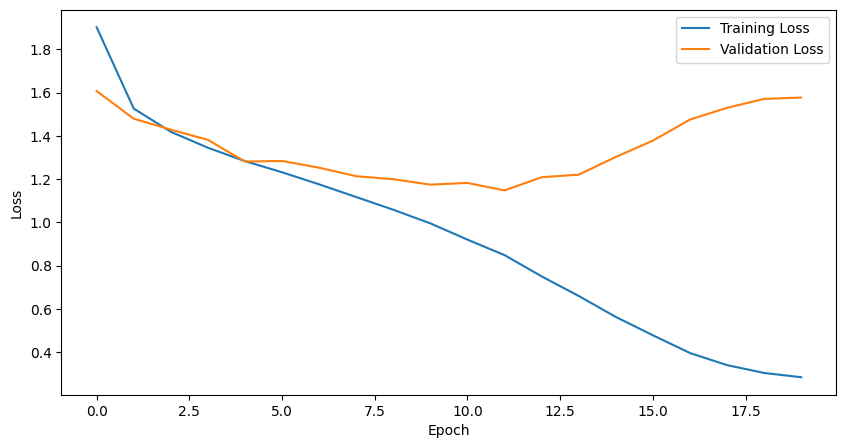

In [380]:
epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()

train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=epochs, valid_every=1)